In [1]:
import pandas as pd
import pickle,os, copy
os.environ["PATH_TO_DEEP_FOLDER"] = "/rds/general/user/dl2119/home/deep_generalizability"

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys
import scipy
import seaborn as sns
from sklearn.isotonic import IsotonicRegression

import re

import margin_flatness as mf
import margin_flatness.postprocessing as mf_post

import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams["figure.figsize"] = (13,9)

COLORS = plt.cm.tab20(np.arange(20))

CORRECT_COLOR_IDX = 3
INCORRECT_COLOR_IDX = 1

In [24]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "CIFAR10"

exp_name = ""

exp_name = "LeNet_short" #"May19_00-32-38_cx3-7-9.cx3.hpc.ic.ac.uk"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp_name)


In [5]:
stats_df = mf_post.stats_plotting.get_end_stats(experiment_folder, step=-1)


In [6]:
stats_df.sort_values(by="Acc Test Mean", ascending=False)

KeyError: 'Acc Test Mean'

## Get cached data

In [ ]:
# mf.save_load.join_cached_sub_data(experiment_folder, "point_traces", -1, "May18_23-54-38")
# mf.save_load.join_cached_sub_data(experiment_folder, "point_loss", -1, "May18_23-54-28")
# mf.save_load.join_cached_sub_data(experiment_folder, "inp_out_jacobian", -1, "May18_23-58-31")

In [ ]:
len(all_point_loss)

In [31]:
all_point_traces, _ = mf.save_load.load_cached_data(experiment_folder, "point_traces", step=-1, time_stamp="May25_16-21-58-862654-joined")
# all_point_loss, _ = mf.save_load.load_cached_data(experiment_folder, "point_loss", step=-1, time_stamp="May25_17-48-36-470248-joined")
inp_out_jacobian, _ = mf.save_load.load_cached_data(experiment_folder, "inp_out_jacobian", step=-1, time_stamp="May25_16-19-33-203813-joined")
# output_margins, _ = mf.save_load.load_cached_data(experiment_folder, "output_margins", step=-1, time_stamp="May25_15-00-54-625745-joined")

# post_dict = {"traces": all_point_traces, "losses": all_point_loss, "jacobian": inp_out_jacobian, "margins": output_margins}
post_dict = {"traces": all_point_traces, "jacobian": inp_out_jacobian,}

train_loss_acc, _ = mf.save_load.load_cached_data(experiment_folder, "model_loss_acc", step=-1, time_stamp="May25_14-28-14-776489-joined")
test_loss_acc, _ = mf.save_load.load_cached_data(experiment_folder, "model_loss_acc", step=-1, time_stamp="May25_14-28-14-733072-joined")
loss_acc_dict = {k: {"acc_train": train_loss_acc[k][1]['0'], "acc_test": test_loss_acc[k][1]['0'], "loss_train": train_loss_acc[k][0]['0'], "loss_test": test_loss_acc[k][0]['0']} for k in train_loss_acc}
loss_acc_df = pd.DataFrame(data=loss_acc_dict.values(), index=loss_acc_dict.keys())

# loss_acc_dict = {losses: }

# Get processed DF

In [32]:
def get_all_kendalls(exp_post_dict, exp_ids, configs):
    kendall_coeffs = {}
    
    for k1 in exp_post_dict.keys():
        for k2 in exp_post_dict.keys():
            # We continue since kendall is symmetric
            if (k2, k1) in kendall_coeffs or k1 == k2:
                continue
            kendall_coeffs[(k1, k2)] = {}

            for exp_id in exp_ids:
                kendall_coeffs[(k1, k2)][exp_id] = mf_post.correlation.get_kendall(exp_post_dict[k1][exp_id]['0'], exp_post_dict[k2][exp_id]['0'], remove_outliers=True).correlation
    
    hp_df = get_hp_df(configs)        
    kendall_coeffs_df = pd.DataFrame(kendall_coeffs)
    return pd.concat([kendall_coeffs_df, hp_df], axis=1)


def get_all_r2(exp_post_dict, exp_ids, configs):
    r2_coeffs = {}
    
    for k1 in exp_post_dict.keys():
        for k2 in exp_post_dict.keys():
            # We continue only if equal. r2 is not symmetric, so we get the max
            if k1 == k2:
                continue
            
            if (k1, k2) not in r2_coeffs:
                r2_coeffs[(k1, k2)] = {}

            for exp_id in exp_ids:
                if (k2, k1) in r2_coeffs:
                    try:
                        r2_coeffs[(k2, k1)][exp_id] = max(r2_coeffs[(k2, k1)][exp_id], mf_post.correlation.get_isotonic_r_squared(exp_post_dict[k1][exp_id]['0'], exp_post_dict[k2][exp_id]['0'], remove_outliers=True, increasing="auto"))
                    except:
                        pass
                else:
                    try:
                        r2_coeffs[(k1, k2)][exp_id] = mf_post.correlation.get_isotonic_r_squared(exp_post_dict[k1][exp_id]['0'], exp_post_dict[k2][exp_id]['0'], remove_outliers=True, increasing="auto") 
                    except:
                        r2_coeffs[(k1, k2)][exp_id] = np.nan
            
    hp_df = get_hp_df(configs)        
    r2_coeffs_df = pd.DataFrame(r2_coeffs)
    return pd.concat([r2_coeffs_df, hp_df], axis=1)


def get_hp_df(configs):
    cfs_hp = mf_post.utils.get_hp(configs)
    cfs_hp_df = configs[list(cfs_hp.keys())]
    return cfs_hp_df

cfgs = mf.save_load.load_configs(experiment_folder)
exp_ids = list(cfgs.index)
# exp_ids = ["1621270824.0509984"]
kendall_df = get_all_kendalls(post_dict, exp_ids, cfgs)
r2_df = get_all_r2(post_dict, exp_ids, cfgs)


In [37]:
def get_subset_filter(df, config_subset):
    index_filter = [True] * len(df)
    for k, v in config_subset.items():
        index_filter = index_filter & (df[k] == v)
    return index_filter

def subset_df(df, p_types, config_subset):
    index_filter = [True] * len(df)
    for k, v in config_subset.items():
        index_filter = index_filter & (df[k] == v)
            
    if len(p_types) == 1:
        return df[df.columns[[p_types[0] in c for c in df.columns]]][index_filter]
    
    col_filter = []
    for c in df.columns:
        if c[0] in p_types and c[1] in p_types:
            col_filter.append(True)
        else:
            col_filter.append(False)
    return df[df.columns[col_filter]][index_filter]

In [35]:


kendall_df_new = pd.concat([kendall_df, loss_acc_df], axis=1)
r2_df_new = pd.concat([r2_df, loss_acc_df], axis=1)

# kendall_df_new[kendall_df_new["optimizer"] == "RMSProp"].sort_values("train_loss")
# kendall_df_new.sort_values("train_loss").tail(25)
r2_df_new[r2] # .groupby(["criterion", "optimizer", "learning_rate"]).mean()#.sort_values(("margins", "jacobian"))#.head(50)#[kendall_df_new["criterion"] == "cross-entropy"].sort_values(("traces", "losses"), ascending=False).head(40) # .groupby(["learning_rate","optimizer", "criterion"]).mean() #.loc["1621270824.0509984"]

(traces, jacobian)  (jacobian, traces)  \
criterion     optimizer learning_rate                                           
MSE           Adam      0.000001                 0.014688                 NaN   
                        0.000005                 0.018801                 NaN   
                        0.000010                 0.028751                 NaN   
                        0.000025                 0.047445                 NaN   
                        0.000050                 0.061059                 NaN   
                        0.000075                 0.064116                 NaN   
              RMSProp   0.000001                 0.015437                 NaN   
                        0.000005                 0.021464                 NaN   
                        0.000010                 0.021858                 NaN   
                        0.000025                 0.051635                 NaN   
                        0.000050                 0.052506                 NaN   
                        0.000075                 0.053000                 NaN   
              SGD       0.005000                 0.034619                 NaN   
                        0.010000                 0.052732                 NaN   
                        0.025000                 0.042159                 NaN   
                        0.050000                 0.054969                 NaN   
                        0.075000                 0.074388                 NaN   
                        1.000000                 0.138198                 NaN   
cross-entropy Adam      0.000001                 0.017817                 NaN   
                        0.000005                 0.112087                 NaN   
                        0.000010                 0.136213                 NaN   
                        0.000025                 0.147698                 NaN   
                        0.000050                 0.211582                 NaN   
                        0.000075                 0.269281                 NaN   
              RMSProp   0.000001                 0.016549                 NaN   
                        0.000005                 0.082463                 NaN   
                        0.000010                 0.127591                 NaN   
                        0.000025                 0.141983                 NaN   
                        0.000050                 0.198997                 NaN   
                        0.000075                 0.284639                 NaN   
              SGD       0.005000                 0.699780                 NaN   
                        0.010000                 0.761365                 NaN   
                        0.025000                 0.776170                 NaN   
                        0.050000                 0.699843                 NaN   
                        0.075000                 0.702002                 NaN   
                        1.000000                 1.000000                 NaN   

                                       acc_train  acc_test  loss_train  \
criterion     optimizer learning_rate                                    
MSE           Adam      0.000001        0.250667  0.250217    0.088501   
                        0.000005        0.373533  0.373067    0.078473   
                        0.000010        0.422050  0.416800    0.074241   
                        0.000025        0.481000  0.460633    0.068279   
                        0.000050        0.544117  0.503800    0.061690   
                        0.000075        0.577217  0.515867    0.057958   
              RMSProp   0.000001        0.244367  0.244550    0.088911   
                        0.000005        0.365150  0.365550    0.079097   
                        0.000010        0.413267  0.410683    0.074959   
                        0.000025        0.481733  0.464400    0.068366   
                        0.000050        0.529700  0.492800    0.063072  

# Plot a histogram for kendall and isotonic R^2 value. 

In [22]:
r2_df.sort_values(("traces","jacobian"), ascending=False)

,"(traces, jacobian)","(jacobian, traces)",batch_train_size,criterion,learning_rate,optimizer,seed,weight_decay
1621712994.9740756,1.0,NaN,128,cross-entropy,1,SGD,0,0
1621713086.0385306,1.0,NaN,128,cross-entropy,0.025,SGD,5,0
1621723180.3606398,1.0,NaN,128,cross-entropy,0.005,SGD,10,0
1621723181.7773988,1.0,NaN,256,cross-entropy,0.005,SGD,10,0
1621713225.772196,1.0,NaN,256,cross-entropy,0.00005,RMSProp,10,0
...,...,...,...,...,...,...,...,...
1621713263.2869356,NaN,NaN,128,cross-entropy,0.000005,Adam,5,0
1621713060.4051876,NaN,NaN,256,cross-entropy,1,SGD,5,0
1621723280.0908508,NaN,NaN,256,cross-entropy,1,SGD,0,0.0001
1621712996.9256675,NaN,NaN,256,cross-entropy,1,SGD,0,0


In [44]:
config_subset = {"optimizer": "SGD", "learning_rate": 0.025, "batch_train_size": 256, "weight_decay": 0}

"1621786712.1640303" # MSE
"1621786677.325591" # SGD
kendall_df_new[get_subset_filter(r2_df, config_subset)]


,"(traces, jacobian)",batch_train_size,criterion,learning_rate,optimizer,seed,weight_decay,acc_train,acc_test,loss_train,loss_test
1621786648.2537081,0.920798,256,cross-entropy,0.025,SGD,0,0,0.9536,0.5624,0.155687,3.559229
1621786660.9983337,0.908455,256,cross-entropy,0.025,SGD,5,0,0.9216,0.5370,0.254365,3.943879
1621786669.1946497,0.063546,256,MSE,0.025,SGD,0,0,0.6716,0.5460,0.046609,0.061014
1621786677.325591,0.911728,256,cross-entropy,0.025,SGD,10,0,0.9298,0.5606,0.214393,3.188200
1621786689.6460016,0.056168,256,MSE,0.025,SGD,5,0,0.7182,0.5846,0.042699,0.057799
1621786712.1640303,0.109219,256,MSE,0.025,SGD,10,0,0.7220,0.5944,0.042222,0.057079


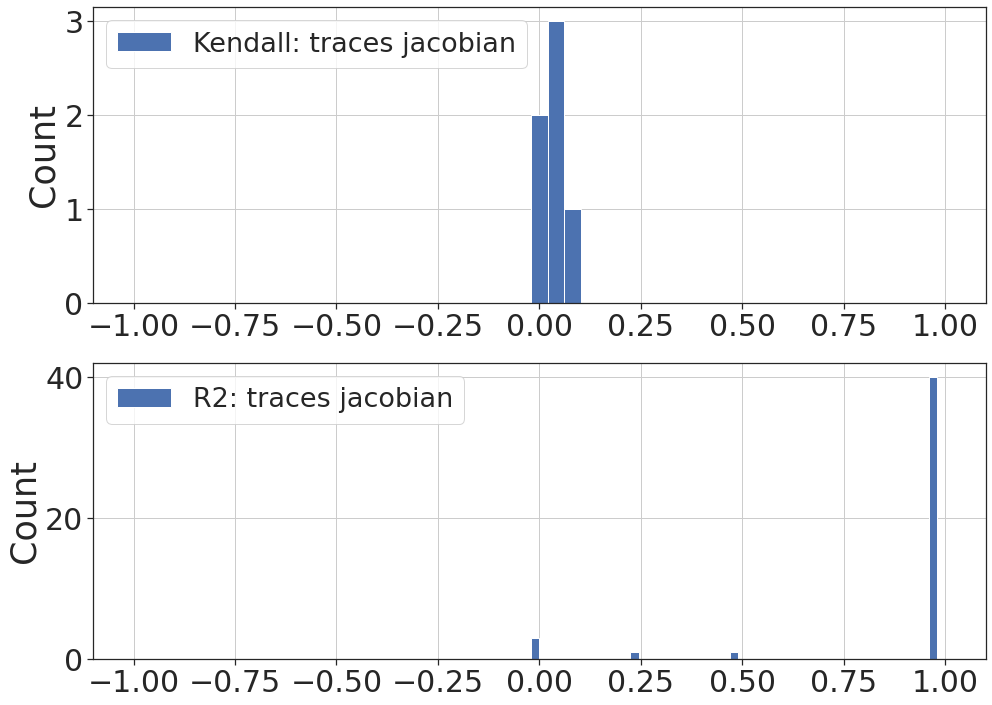

In [11]:
import seaborn as sns

config_subset = {"criterion": "cross-entropy", "optimizer": "SGD"}
p_types = ["traces"]

kendall_dict_to_use = subset_df(kendall_df, p_types, config_subset)
r2_dict_to_use = subset_df(r2_df, p_types, config_subset)
    
    
kendall_values = list(np.abs(kendall_dict_to_use.values.T))
r2_values = list(r2_dict_to_use.values.T)
labels = list(kendall_dict_to_use.columns)
    
sns.set(style="ticks")
f, (ax_kendall_hist, ax_r2_hist) = plt.subplots(2, figsize=(16,12))

ax_kendall_hist.hist(kendall_values, rwidth=10, bins=np.linspace(-1, 1, 50), alpha=1, label=["Kendall: {} {}".format(l[0], l[1]) for l in labels])
ax_kendall_hist.tick_params(axis='both', labelbottom=True, labelsize=30)
ax_kendall_hist.set_ylabel(ylabel="Count", fontsize=35)
ax_kendall_hist.grid(b=True, which='major')

ax_r2_hist.hist(r2_values, rwidth=10, bins=np.linspace(-1, 1, 50), alpha=1, label=["R2: {} {}".format(l[0], l[1]) for l in labels]) # TODO: Messed up due to Nan values. 
ax_r2_hist.tick_params(axis='both', labelbottom=True, labelsize=30)
ax_r2_hist.set_ylabel(ylabel="Count", fontsize=35)
ax_r2_hist.grid(b=True, which='major')

# ax_r2_hist.set_xlim(-0.2, 0.2)
# ax_kendall_hist.set_xlim(-0.2, 0.2)

ax_kendall_hist.legend(loc="upper left", fontsize=27) #, bbox_to_anchor=(0.45, 0.95))
ax_r2_hist.legend(loc="upper left", fontsize=27) #, bbox_to_anchor=(0.3875, 0.95))


# f.savefig("../figs/kendall_r2_{}_{}".format(criterion_type, p_types), dpi=300, bbox_inches = "tight",)

In [ ]:
import seaborn as sns

criterion_type = "MSE"
p_types = ["traces"]

kendall_dict_to_use = subset_df(kendall_df, p_types, criterion_type)
r2_dict_to_use = subset_df(r2_df, p_types, criterion_type)
    
    
kendall_values = list(np.abs(kendall_dict_to_use.values.T))
r2_values = list(r2_dict_to_use.values.T)
labels = list(kendall_dict_to_use.columns)
    
sns.set(style="ticks")
f, (ax_kendall_hist, ax_r2_hist) = plt.subplots(2, figsize=(16,12))

ax_kendall_hist.hist(kendall_values, rwidth=10, bins=np.linspace(-1, 1, 50), alpha=1, label=["Kendall: {} {}".format(l[0], l[1]) for l in labels])
ax_kendall_hist.tick_params(axis='both', labelbottom=True, labelsize=30)
ax_kendall_hist.set_ylabel(ylabel="Count", fontsize=35)
ax_kendall_hist.grid(b=True, which='major')

ax_r2_hist.hist(r2_values, rwidth=10, bins=np.linspace(-1, 1, 50), alpha=1, label=["R2: {} {}".format(l[0], l[1]) for l in labels])
ax_r2_hist.tick_params(axis='both', labelbottom=True, labelsize=30)
ax_r2_hist.set_ylabel(ylabel="Count", fontsize=35)
ax_r2_hist.grid(b=True, which='major')

# ax_r2_hist.set_xlim(-0.2, 0.2)
# ax_kendall_hist.set_xlim(-0.2, 0.2)

ax_kendall_hist.legend(loc="upper left", fontsize=27) #, bbox_to_anchor=(0.45, 0.95))
ax_r2_hist.legend(loc="upper left", fontsize=27) #, bbox_to_anchor=(0.3875, 0.95))


# f.savefig("../figs/kendall_r2_{}_{}".format(criterion_type, p_types), dpi=300, bbox_inches = "tight",)

# Scatter Plot non-aggregated


In [ ]:
r2_df[r2_df["criterion"] == "MSE"].sort_values(("traces", "jacobian"), ascending=False)

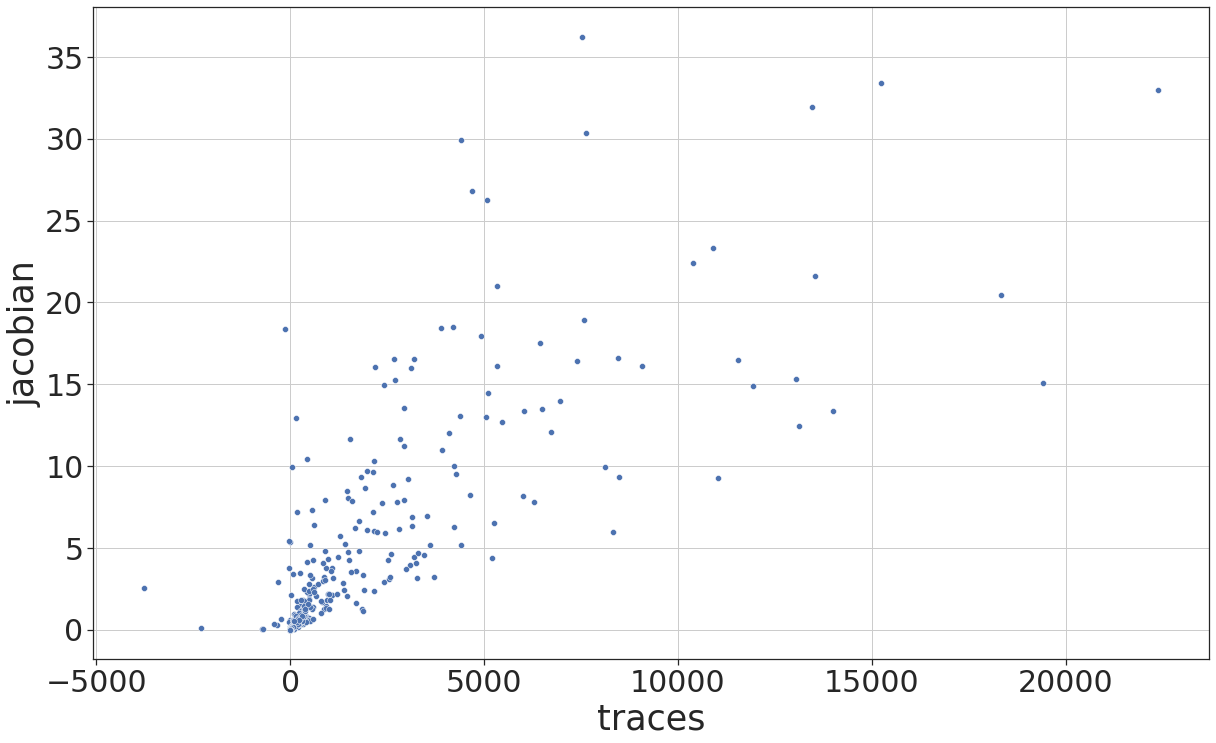

In [64]:
exp_dict = post_dict

x_type = "traces"
y_type = "jacobian"
exp_id = "1621786712.1640303"
exp_id = "1621786648.2537081" # CE
with_isotonic = False

# print(np.mean(exp_dict["losses"][exp_id]['0']))
    
x_data = exp_dict[x_type][exp_id]['0']
y_data = exp_dict[y_type][exp_id]['0'] # exp_dict[y_type][exp_id]['0']
    
sns.set(style="ticks")

f, ax1 = plt.subplots(1, figsize=(20,12))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))
if with_isotonic:
    iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
    y_predicted = iso_reg.predict(x_data)
    sns.scatterplot(x=x_data, y=y_predicted, ax=ax1)
    
ax1.set_ylabel(ylabel=y_type, fontsize=35)
ax1.set_xlabel(xlabel=x_type, fontsize=35)
ax1.tick_params(axis='both', labelbottom=True, labelsize=30)

# ax1.set_ylim(-250, 3500)
ax1.grid(b=True, which='major')
# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)


# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")




f.savefig(os.path.join(root_folder, "figs", "scatter_{}_{}_{}_{}.png".format("CE", exp_id, data_name, exp_name)), dpi=300, bbox_inches = "tight",)

# Scatter Plot : Aggregated

In [ ]:
def get_aggregation(exp_post_dict, exp_ids):
    res_dict = {}
    for k in exp_post_dict:
        res_dict[k] = {"mean": {}, "max": {}, "min": {}}
        for exp_id in exp_ids:
            res_dict[k]["mean"][exp_id] = np.mean(exp_post_dict[k][exp_id]['0'])
            res_dict[k]["max"][exp_id] = np.max(exp_post_dict[k][exp_id]['0'])
            res_dict[k]["min"][exp_id] = np.min(exp_post_dict[k][exp_id]['0'])
    return res_dict



def get_post_data_vals(data_type, data_subtype, post_dict, acc_dict, exp_id):
    exp_ids = list(acc_dict.keys())
    assert data_type in post_dict or data_type == "acc"    
    if "acc" != data_type:
        return post_dict[data_type][data_subtype][exp_id]
    else:
        if x_subtype == "test":
            return acc_dict[exp_id]['0'][1]
        else:
            return acc_dict[exp_id]['0'][0]


In [ ]:
exp_dict = ce_dict
exp_ids = ce_stats_df.index
agg_dict = get_aggregation(exp_dict,  exp_ids)
acc_dict = ce_acc

x_type = "traces"
x_subtype = "mean"
y_type = "acc"
y_subtype = "test"

with_isotonic = True


x_data, y_data = [], []

for exp_id in exp_ids:
    x_data.append(get_post_data_vals(x_type, x_subtype, agg_dict, acc_dict, exp_id))
    y_data.append(get_post_data_vals(y_type, y_subtype, agg_dict, acc_dict, exp_id))


sns.set(style="ticks")

f, ax1 = plt.subplots(1, figsize=(16,12))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))
# if with_isotonic:
#     iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
#     y_predicted = iso_reg.predict(x_data)
#     sns.scatterplot(x=x_data, y=y_predicted, ax=ax1)
    
ax1.set_ylabel(ylabel=y_type, fontsize=22)
ax1.set_xlabel(xlabel=x_type, fontsize=22)
# ax1.set_ylim(-250, 3500)
ax1.grid(b=True, which='major')
# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

# Plot every point on one plot

In [ ]:
def get_all_points(exp_post_dict, exp_ids, x_type, y_type, use_isotonic=False, keep_kendall_threshold=0.3): 
    x_res_arr, y_res_arr = [], []
    for exp_id in exp_ids:
        x_data = exp_post_dict[x_type][exp_id]['0']
        y_data = exp_post_dict[y_type][exp_id]['0']
        if use_isotonic:
            x_data, y_data = isotonic_outlier_removal(x_data, y_data, 0.02)
            iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
            y_predicted = iso_reg.predict(x_data)
#             y_predicted += (x_data - np.min(x_data)) * 0.00000002 / np.linalg.norm(x_data) * np.linalg.norm(y_data)
            x_data = y_predicted
        if abs(mf_post.correlation.get_kendall(x_data, y_data).correlation) >= keep_kendall_threshold:
            x_res_arr.append(x_data)
            y_res_arr.append(y_data)
    return np.array(x_res_arr).flatten(), np.array(y_res_arr).flatten()


In [ ]:
# plt.scatter(x_data, y_data)

# iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
# y_predicted = iso_reg.predict(x_data)
# plt.scatter(x_data, y_predicted)

# mf_post.correlation.linregress_outliers(x_data, y_data)

In [ ]:
def get_all_points(exp_post_dict, exp_ids, x_type, y_type, use_isotonic=False, keep_kendall_threshold=0.3): 
    x_res_arr, y_res_arr = [], []
    for exp_id in exp_ids:
        x_data = exp_post_dict[x_type][exp_id]['0']
        y_data = exp_post_dict[y_type][exp_id]['0']
        if use_isotonic:
            x_data, y_data = isotonic_outlier_removal(x_data, y_data, 0.02)
            iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
            y_predicted = iso_reg.predict(x_data)
#             y_predicted += (x_data - np.min(x_data)) * 0.00000002 / np.linalg.norm(x_data) * np.linalg.norm(y_data)
            x_data = y_predicted
        if abs(mf_post.correlation.get_kendall(x_data, y_data).correlation) >= keep_kendall_threshold:
            x_res_arr.append(x_data)
            y_res_arr.append(y_data)
    return np.array(x_res_arr).flatten(), np.array(y_res_arr).flatten()


In [ ]:
loss_type = "MSE"
x_type = "traces"
y_type = "jacobian"
do_isotonic = False

if loss_type == "CE":
    exp_name = ce_exp
    exp_ids = ce_stats_df.index
    x_data, y_data = get_all_points(ce_dict, exp_ids, x_type, y_type, use_isotonic=do_isotonic, keep_kendall_threshold=0)
else:
    exp_name = mse_exp
    exp_ids = mse_stats_df.index
    x_data, y_data = get_all_points(mse_dict, exp_ids, x_type, y_type, use_isotonic=do_isotonic, keep_kendall_threshold=-1)
    
c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(24,12))


sns.scatterplot(x=x_data, y=y_data, ax=ax1, label="Kendall Coeff: {:.2f} \nR2 score: {:.2f}".format(mf_post.correlation.get_kendall(y_data, x_data).correlation, mf_post.correlation.get_isotonic_r_squared(y_data, x_data)))

ax1.tick_params(axis='both', labelbottom=True, labelsize=30)

ax1.set_ylabel(ylabel=y_type, fontsize=35)
if do_isotonic:
    ax1.set_xlabel(xlabel="g_theta({})".format(x_type), fontsize=35)
else:
    ax1.set_xlabel(xlabel="{}".format(x_type), fontsize=35)
ax1.legend(loc="best", fontsize=32) #, bbox_to_anchor=(0.3875, 0.95))
ax1.grid(b=True, which='major')



# ax1.text(x=0.99, y=0.9, transform=ax1.transAxes, s="Kendall Coeff: {:.2f} \n R2 score: {:.2f}".format(mf_post.correlation.get_kendall(y_data, x_data).correlation, mf_post.correlation.get_isotonic_r_squared(y_data, x_data)) ,\
#          fontsize=30, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

# iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
# y_predicted = iso_reg.predict(x_data)
# sns.scatterplot(x=x_data, y=y_predicted, ax=ax1, color="red")


if loss_type == "CE" and y_type == "traces":
    axins2 = inset_axes(ax1, width=4, height=4, loc=2)
    sns.scatterplot(x=x_data, y=y_data, ax=axins2)

    # sub region of the original image
    x1, x2, y1, y2 = -1000, 5000, -1000, 5000
    
    axins2.set_xlim(x1, x2)
    axins2.set_ylim(y1, y2)

    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")
#     axins2.tick_params(None) # TODO unset tick_params



f.savefig("../figs/all_points_{}_{}_{}_{}".format(loss_type, x_type, y_type, do_isotonic), dpi=300, bbox_inches = "tight",)


### Using with Isotonic Regression

In [ ]:

from sklearn.neighbors import LocalOutlierFactor

def get_outlier_filter(x_data, y_data):
    x_data, y_data = np.array(x_data), np.array(y_data)
    #     if len(x_data) < 5:
    #         return np.array([True]*len(x_data)) # They are all outliers since we don't have enough datapoints
    combined_data = np.concatenate([x_data.reshape(len(x_data), 1), y_data.reshape(len(y_data), 1)], axis=1)

    clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
    outlier_filter = clf.fit_predict(combined_data) == 1

       
    return x_data[outlier_filter], y_data[outlier_filter]

# get_outlier_filter(np.array(x_data), np.array(y_data))



# Plot accuracy vs correlation

In [ ]:
ce_all_point_traces, _ = mf.save_load.load_cached_data(ce_experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
ce_all_point_output_margins, _ = mf.save_load.load_cached_data(ce_experiment_folder, "output_margins", step=-1, time_stamp="Dec02_20-51-39")


mse_all_point_traces, _ = mf.save_load.load_cached_data(mse_experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
mse_all_point_output_margins, _ = mf.save_load.load_cached_data(mse_experiment_folder, "output_margins", step=-1, time_stamp="Dec02_18-53-57")


In [ ]:

num_nets = 1

ce_kendall_coeffs_train_acc_dict = {}
ce_kendall_coeffs_test_acc_dict = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_kendall_coeffs_train_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, ce_stats_df["Acc Train Mean"][exp_id])
        ce_kendall_coeffs_test_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, ce_stats_df["Acc Test Mean"][exp_id])

mse_kendall_coeffs_train_acc_dict = {}
mse_kendall_coeffs_test_acc_dict = {}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = mse_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        mse_kendall_coeffs_train_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, mse_stats_df["Acc Train Mean"][exp_id])
        mse_kendall_coeffs_test_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, mse_stats_df["Acc Test Mean"][exp_id])

ce_kendall_coeffs_train_acc_arr = np.array(list(ce_kendall_coeffs_train_acc_dict.values()))
mse_kendall_coeffs_train_acc_arr = np.array(list(mse_kendall_coeffs_train_acc_dict.values()))
ce_kendall_coeffs_test_acc_arr = np.array(list(ce_kendall_coeffs_test_acc_dict.values()))
mse_kendall_coeffs_test_acc_arr = np.array(list(mse_kendall_coeffs_test_acc_dict.values()))

In [ ]:
import seaborn as sns
f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

ax1_hist.hist([ce_kendall_coeffs_train_acc_arr[:, 1], mse_kendall_coeffs_train_acc_arr[:, 1]], color=['darkblue','orange'], alpha=0.5, label=["Cross Entropy", "MSE"])

ax1_hist.grid(b=True, which='major')

ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Training Accuracy", fontsize=22)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.35, 0.88))

f.savefig("../figs/train_acc", dpi=300, bbox_inches = "tight",)

In [ ]:
import seaborn as sns
f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

ax1_hist.hist([ce_kendall_coeffs_test_acc_arr[:, 1], mse_kendall_coeffs_test_acc_arr[:, 1]], color=['darkblue','orange'], alpha=0.5, label=["Cross Entropy", "MSE"])

ax1_hist.grid(b=True, which='major')

ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Test Accuracy", fontsize=22)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.35, 0.88))

f.savefig("../figs/test_acc", dpi=300, bbox_inches = "tight",)

# Scratch

In [ ]:

num_nets = 1

ce_r2_coeffs_point_output = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(ce_all_point_traces[exp_id]["{}".format(nn_idx)])
        y_data = np.array(ce_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        ce_r2_coeffs_point_output[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")


ce_r2_coeffs_point_loss = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_loss[exp_id]["{}".format(nn_idx)]
        ce_r2_coeffs_point_loss[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")

        
ce_r2_coeffs_output_margins = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_r2_coeffs_output_margins[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")


In [ ]:

num_nets = 1

ce_test_acc_hess = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(ce_all_point_traces[exp_id]["{}".format(nn_idx)])
        y_data = np.array(ce_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        ce_test_acc_hess[exp_id] = [ce_stats_df.loc[exp_id]["Acc Test Mean"], np.mean(ce_all_point_loss[exp_id]["{}".format(nn_idx)])]

ce_test_acc_hess_arr = np.array(list(ce_test_acc_hess.values()))

mse_test_acc_hess = {}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(mse_all_point_traces[exp_id]["{}".format(nn_idx)])
#         y_data = np.array(mse_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        mse_test_acc_hess[exp_id] = [mse_stats_df.loc[exp_id]["Acc Test Mean"], np.mean(mse_all_point_loss[exp_id]["{}".format(nn_idx)])]#mse_stats_df.loc[exp_id]["Loss Train Mean"]] #np.mean(ce_all_point_traces[exp_id]["{}".format(nn_idx)])]

mse_test_acc_hess_arr = np.array(list(mse_test_acc_hess.values()))

In [ ]:

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = mse_test_acc_hess_arr[:, 1]
y_data = mse_test_acc_hess_arr[:, 0]

print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [ ]:

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = mse_test_acc_hess_arr[:, 1]
y_data = mse_test_acc_hess_arr[:, 0]
print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [ ]:


ce_sample_flatness_old, _ = mf.save_load.load_cached_data(ce_experiment_folder, "sample_average_flatness_pointwise", step=-1, time_stamp="Apr07_18-31-05")
ce_sample_flatness, _ = mf.save_load.load_cached_data(ce_experiment_folder, "sample_average_flatness_pointwise", step=-1, time_stamp="Apr08_01-23-18")



In [ ]:
exp_id = list(ce_sample_flatness_old.keys())[0]
sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = ce_sample_flatness[exp_id]['0']
y_data = ce_all_point_traces[exp_id]['0']
# y_data = ce_sample_flatness_old[exp_id]['0']
print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [ ]:

num_nets = 1

ce_test_acc_hess = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(ce_sample_flatness[exp_id]["{}".format(nn_idx)])
        y_data = np.array(ce_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        ce_test_acc_hess[exp_id] = [ce_stats_df.loc[exp_id]["Acc Test Mean"], np.mean(ce_sample_flatness[exp_id]["{}".format(nn_idx)])]

ce_test_acc_hess_arr = np.array(list(ce_test_acc_hess.values()))

# mse_test_acc_hess = {}
# for exp_id in mse_stats_df.index:
#     for nn_idx in range(num_nets):
#         x_data = np.array(mse_all_point_traces[exp_id]["{}".format(nn_idx)])
# #         y_data = np.array(mse_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
#         mse_test_acc_hess[exp_id] = [mse_stats_df.loc[exp_id]["Acc Test Mean"], mse_stats_df.loc[exp_id]["Loss Train Mean"]] #np.mean(ce_all_point_traces[exp_id]["{}".format(nn_idx)])]

# mse_test_acc_hess_arr = np.array(list(mse_test_acc_hess.values()))

In [ ]:

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = ce_test_acc_hess_arr[:, 1]
y_data = ce_test_acc_hess_arr[:, 0]
print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [ ]:
np.argmax([0,1,2])

In [ ]:
def isotonic_outlier_removal(x_data, y_data, percent_outlier_remove=0.05, increasing="auto"):
    num_outlier_remove = int(len(x_data)*percent_outlier_remove)
    for _ in range(num_outlier_remove):
        iso_reg = IsotonicRegression(increasing=increasing).fit(x_data, y_data)
        y_predicted = iso_reg.predict(x_data)
        idx_max = np.argmax(np.abs(y_predicted - y_data))
        x_data = np.delete(x_data, idx_max)
        y_data = np.delete(y_data, idx_max)
    return x_data, y_data


def get_isotonic_r_squared(x_data, y_data, remove_outliers=False, increasing=False):
    if len(x_data) == 0:
        return 0, 0, 0, None, None
    x_data, y_data = np.array(x_data), np.array(y_data)

    if remove_outliers:
        outlier_filter = get_outlier_filter(x_data, y_data)
        x_data, y_data = x_data[outlier_filter], y_data[outlier_filter]
        f
    iso_reg = IsotonicRegression(increasing=increasing).fit(x_data, y_data)
    y_predicted = iso_reg.predict(x_data)
    return r2_score(y_data, y_predicted)


In [ ]:
slopes = []
weights = []

ce_models = mf.save_load.get_all_models(ce_experiment_folder, step=-1, device=None)

num_nets = 1

ce_all_x_data = []
ce_all_y_data = []
counter = 0
for exp_id in ce_stats_df.index:
    if counter > 100:
        break
    counter += 1
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_loss[exp_id]["{}".format(nn_idx)] #ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        x_data, y_data = isotonic_outlier_removal(x_data, y_data, 0.02)
        iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
        y_predicted = iso_reg.predict(x_data)
        y_predicted_org = np.copy(y_predicted)
        y_predicted += (x_data - np.min(x_data)) * 0.00002 / np.linalg.norm(x_data) * np.linalg.norm(y_data)

        slope, intercept, correct_r_value, _, _ = mf_post.correlation.linregress_outliers(x_data, y_data)
        y_lin_predicted = np.array(x_data) * float(slope) + intercept

        slopes.append(slope)
        weights.append(mf.utils.get_params_norm(ce_models[exp_id]["0"]))

#         ce_all_x_data.append(np.mean(x_data))
#         ce_all_y_data.append(np.max(y_data))
        
# ce_all_x_data = np.array(ce_all_x_data).flatten()
# ce_all_y_data = np.array(ce_all_y_data).flatten()
     
# exp_name = ce_exp
# x_data = ce_all_x_data
# y_data = ce_all_y_data


    
#         c1 = [1.        , 0.49803922, 0.05490196, 1.        ]


#         f, ax1 = plt.subplots(1, figsize=(16,12))
        
#         sns.scatterplot(x=y_lin_predicted, y=y_data)
# #         sns.scatterplot(x=x_data, y=y_data)
# #         sns.scatterplot(x=y_lin_predicted, y=y_data)
# #         sns.scatterplot(x=y_predicted, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

#         # ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

#         ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
#         ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
#         # ax1.set_ylim(-50, 300)
        
#         print(mf_post.correlation.get_kendall(y_predicted, y_data).correlation)
#         print(mf_post.correlation.get_kendall(y_lin_predicted, y_data).correlation)

#         print(mf_post.correlation.get_kendall(x_data, y_data).correlation)
#         ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="R2 Score: {:.2f}".format(r2_score(y_data, y_lin_predicted)) ,\
#              fontsize=22, verticalalignment='top', horizontalalignment='right',\
#             backgroundcolor='white', color=c2)

#         ax1.grid(b=True, which='major')
#         plt.show()
        

In [ ]:
plt.scatter(slopes, weights)

In [ ]:
def compare_nets(m1, m2, N, inp_dim, seed=0):
    x = torch.randn(N, inp_dim)
    y1 = m1(x)
    y2 = m2(x)
    diff = torch.norm(y1 - y2, dim=1)
    return float(torch.mean(diff).detach().numpy())

m1 = ce_models[ce_stats_df.index[0]]["0"]
m2 = ce_models[ce_stats_df.index[1]]["0"]

N = 100
inp_dim = 28*28

# ce_stats_df.index[0]

arr_dists = []
for i in range(81):
    for j in range(i, 81):
        arr_dists.append(compare_nets(ce_models[ce_stats_df.index[i]]["0"], ce_models[ce_stats_df.index[j]]["0"], N, inp_dim, seed=0))

# compare_nets(m1, m2, 1000, 28*28)


# for exp_id in ce_stats_df.index:
#     for exp_id in ce_stats_df.index:

In [ ]:
import torch

seed = 0
num_datapoints = 100

# m1 = ce_models[ce_stats_df.index[0]]["0"]


train_data, test_data = mf.postprocessing.utils.get_data_for_experiment(experiment_folder)
data = mf.data_getters.get_random_data_subset(train_data, num_datapoints=num_datapoints, seed=seed)

data_loader = DataLoader(data, batch_size=1, shuffle=False)




In [ ]:
m.eval()

res = []

m_new = mf.nets.Nets.DanielNormOutputNet(m)

for i, (inputs, labels) in enumerate(data_loader):

    outputs = m_new(inputs) # get softmax of this 
    temp_res = []
    soft_layer = torch.nn.Softmax(dim=-1)
    for a in np.linspace(1, 10):
        temp_res.append(max(soft_layer(a*outputs).detach().numpy()[0]))
    res.append(temp_res)

In [ ]:
int_arr = []
for i in range(len(res)):
    for j in range(i+1, len(res)):
        int_arr.append(do_intersect(res[i], res[j]))
        if int_arr[-1]:
            print("{} {}".format(i, j))
        
# int_arr

In [ ]:
plt.plot(res[48])
plt.plot(res[71])
# plt.xlim(40, 50)

In [ ]:
arr_dists = np.array([np.array(dict_dists[i]) for i in range(81)])

In [ ]:
def do_intersect(res1, res2):
    for i in range(len(res1)):
        if res1[0] < res2[0]:
            if res1[i] > res2[i]:
                return True
        if res1[0] > res2[0]:
            if res1[i] < res2[i]:
                return True
    return False

In [ ]:
import numpy as np

delta = 2
for _ in range(100):
    a = np.random.random(10)
    a[0] = delta*max(a)


    res1 = []
    for i in np.linspace(0, 100):
        o = np.exp(i*a) / np.sum(np.exp(i*a))
        res1.append(o.dot(o))

    res1 = np.array(res1)


    a = np.random.random(10)
    a[0] = delta*max(a)

    res2 = []
    for i in np.linspace(0, 100):
        o = np.exp(i*a) / np.sum(np.exp(i*a))
        res2.append(o.dot(o))

    res2 = np.array(res2)
    print(do_intersect(res1, res2))

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import os, pickle


from random import random

In [ ]:
train_data = torchvision.datasets.KMNIST("/Users/daniellengyel/deep_generalizability/experiments/KMNIST", train=True,
                                            download=True,
                                            transform=torchvision.transforms.Compose([
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(
                                                    (0.1307,), (0.3081,))
                                            ]))


In [ ]:
train_data.shape

In [ ]:
d = np.array(iter(DataLoader(train_data, batch_size=1, shuffle=True)).next()[0].detach().numpy())

In [ ]:
plt.imshow(d.reshape(28,28), cmap="gray")


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
id_type = "best"

if id_type == "worst":
    exp_id, exp_kendall = min(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
elif id_type == "best":
    exp_id, exp_kendall = max(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
else:
    exp_id, exp_kendall = sorted(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))[len(ce_kendall_coeffs)//2]

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = ce_all_point_output_margins[exp_id]["0"]
y_data = ce_all_point_traces[exp_id]["0"]
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
ax1.set_ylim(-250, 3500)


ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

axins2 = inset_axes(ax1, width=4, height=4, loc=1)
sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# sub region of the original image
x1, x2, y1, y2 = 10, 16, -0.6, 1
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [12]:
r2_df_new

,"(traces, losses)","(traces, jacobian)","(traces, margins)","(losses, traces)","(losses, jacobian)","(losses, margins)","(jacobian, traces)","(jacobian, losses)","(jacobian, margins)","(margins, traces)",...,batch_train_size,criterion,learning_rate,optimizer,seed,weight_decay,acc_train,acc_test,loss_train,loss_test
1621787441.2034013,0.678685,0.729476,0.971338,NaN,0.891396,0.977430,NaN,NaN,0.993934,NaN,...,256,cross-entropy,0.01,SGD,0,0.0001,0.9522,0.5808,0.130931,2.950856
1621786700.9018226,0.044733,0.217437,0.043659,NaN,0.437734,0.738720,NaN,NaN,0.418955,NaN,...,256,MSE,1,SGD,10,0,0.9216,0.5638,0.015690,0.068652
1621790269.6430342,0.082725,0.028982,0.036462,NaN,0.019699,0.794832,NaN,NaN,0.042675,NaN,...,128,MSE,0.025,SGD,10,0.0001,0.7000,0.5888,0.044973,0.056266
1621787496.530556,0.036044,0.145147,0.072186,NaN,0.074712,0.400288,NaN,NaN,0.217906,NaN,...,256,cross-entropy,0.000025,Adam,0,0.0001,0.4092,0.4036,1.726392,1.753100
1621786647.420346,0.046796,0.093137,0.042303,NaN,0.201037,0.440233,NaN,NaN,0.187814,NaN,...,256,cross-entropy,0.000025,Adam,5,0,0.4500,0.4570,1.584049,1.605596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621786706.9549413,0.060177,0.054584,0.048743,NaN,0.053374,0.783191,NaN,NaN,0.039464,NaN,...,128,MSE,0.05,SGD,10,0,0.7984,0.6034,0.030660,0.057727
1621787550.8746219,0.024064,0.138086,0.047980,NaN,0.114278,0.675255,NaN,NaN,0.067792,NaN,...,256,cross-entropy,0.000005,Adam,0,0.0001,0.3100,0.3096,1.997544,1.996431
1621787382.3898637,0.549985,0.784211,0.908260,NaN,0.696798,0.906974,NaN,NaN,0.992961,NaN,...,256,cross-entropy,0.075,SGD,0,0.0001,0.8656,0.5178,0.437320,2.592184
1621787594.1609957,0.138199,0.014171,0.072132,NaN,0.122407,0.780054,NaN,NaN,0.018148,NaN,...,256,cross-entropy,0.000001,Adam,0,0.0001,0.2070,0.2108,2.255276,2.252788


In [5]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "CIFAR10"

exp_name = "LeNet_short"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp_name)

exp_ids = ["1621786700.9018226"]

meta = {"criterion": "cross-entropy", "normalize_output": False}
traces_CE = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "point_traces", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=meta)

meta = {"criterion": "cross-entropy", "normalize_output": True}
traces_new_norm_CE = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "point_traces", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=meta)

# meta = {"criterion": "MSE"}
# traces_MSE = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "point_traces", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=meta)

# meta = {"criterion": "normalized-cross-entropy"}
# traces_norm_CE = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "point_traces", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=meta)




Files already downloaded and verified
Files already downloaded and verified


432it [00:16, 26.80it/s]


Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]

tensor(1.1847, grad_fn=<CopyBackwards>)
tensor(0.0803, grad_fn=<DivBackward0>)


432it [00:15, 27.50it/s]


In [10]:
meta = None # {"criterion": "cross-entropy"}
jacob = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "inp_out_jacobian", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=meta)




Files already downloaded and verified
Files already downloaded and verified


432it [00:00, 1733.32it/s]


In [ ]:
margins = mf_post.postprocess_experiment.compute_on_experiment(experiment_folder, "output_margins", exp_ids, -1, 0, 100, on_test_set=False, device=None, verbose=True, check_cache=False, meta=None)


In [6]:
exp_id = exp_ids[0]
x_data = traces_new_norm_CE[exp_id]['0']
y_data = jacob[exp_id]['0']
plt.scatter(x_data, y_data)
# plt.xlim(-10, 20)
# plt.ylim(-0.1,0.1)

NameError: name 'jacob' is not defined

In [7]:
post_dict
exp_id = "1621270447.8047616"
x_data = post_dict["losses"][exp_id]['0']
y_data = post_dict["jacobian"][exp_id]['0']
plt.scatter(x_data, y_data)
# plt.xlim(-10, 20)
# plt.ylim(-0.1,0.1)

NameError: name 'post_dict' is not defined

In [5]:
mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=False)#, increasing="auto")

KendalltauResult(correlation=0.8611560402224373, pvalue=6.717015901950283e-37)

In [ ]:
loss, acc = mf_post.postprocess_experiment.get_exp_loss_acc(experiment_folder, -1, seed=0, num_train_datapoints=1000, num_test_datapoints=200, device=None, check_cache = True)

In [ ]:
loss_df = pd.DataFrame(data=[loss[k]['0'] for k in loss], index=list(loss.keys()), columns=["train_loss", "test_loss"])
acc_df = pd.DataFrame(data=[acc[k]['0'] for k in acc], index=list(acc.keys()), columns=["train_acc", "test_acc"])

In [ ]:
May19_00-32-38_cx3-7-9.cx3.hpc.ic.ac.uk

In [ ]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "KMNIST"

exp_name = ""

exp_name = "w128_l8_ReLU" # "May19_00-32-38_cx3-7-9.cx3.hpc.ic.ac.uk" # "May19_02-49-40_cx3-3-0.cx3.hpc.ic.ac.uk"#
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp_name)
